LNG Capacity (CBM) is non-stationary, differencing...
Spread
EU-US is non-stationary, differencing...
Spread
ASIA-US is non-stationary, differencing...

✅ Best lag selected: 10 (AIC = -inf)

📊 Mean Squared Errors:
LNG 174K CBM (2-stroke dual fuel) Spot Rate
(avg., $/day): 98879381272856935154989364654982945285603328.00
LNG Capacity (CBM): 56222547901901546487911385714091950231364042752.00
Spread
EU-US: 7257165063643312405462690243163455488.00
Spread
ASIA-US: 25692774069396409018959553042365546496.00
Spread
ASIA-EU: 4310670200891761305126081748587773952.00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


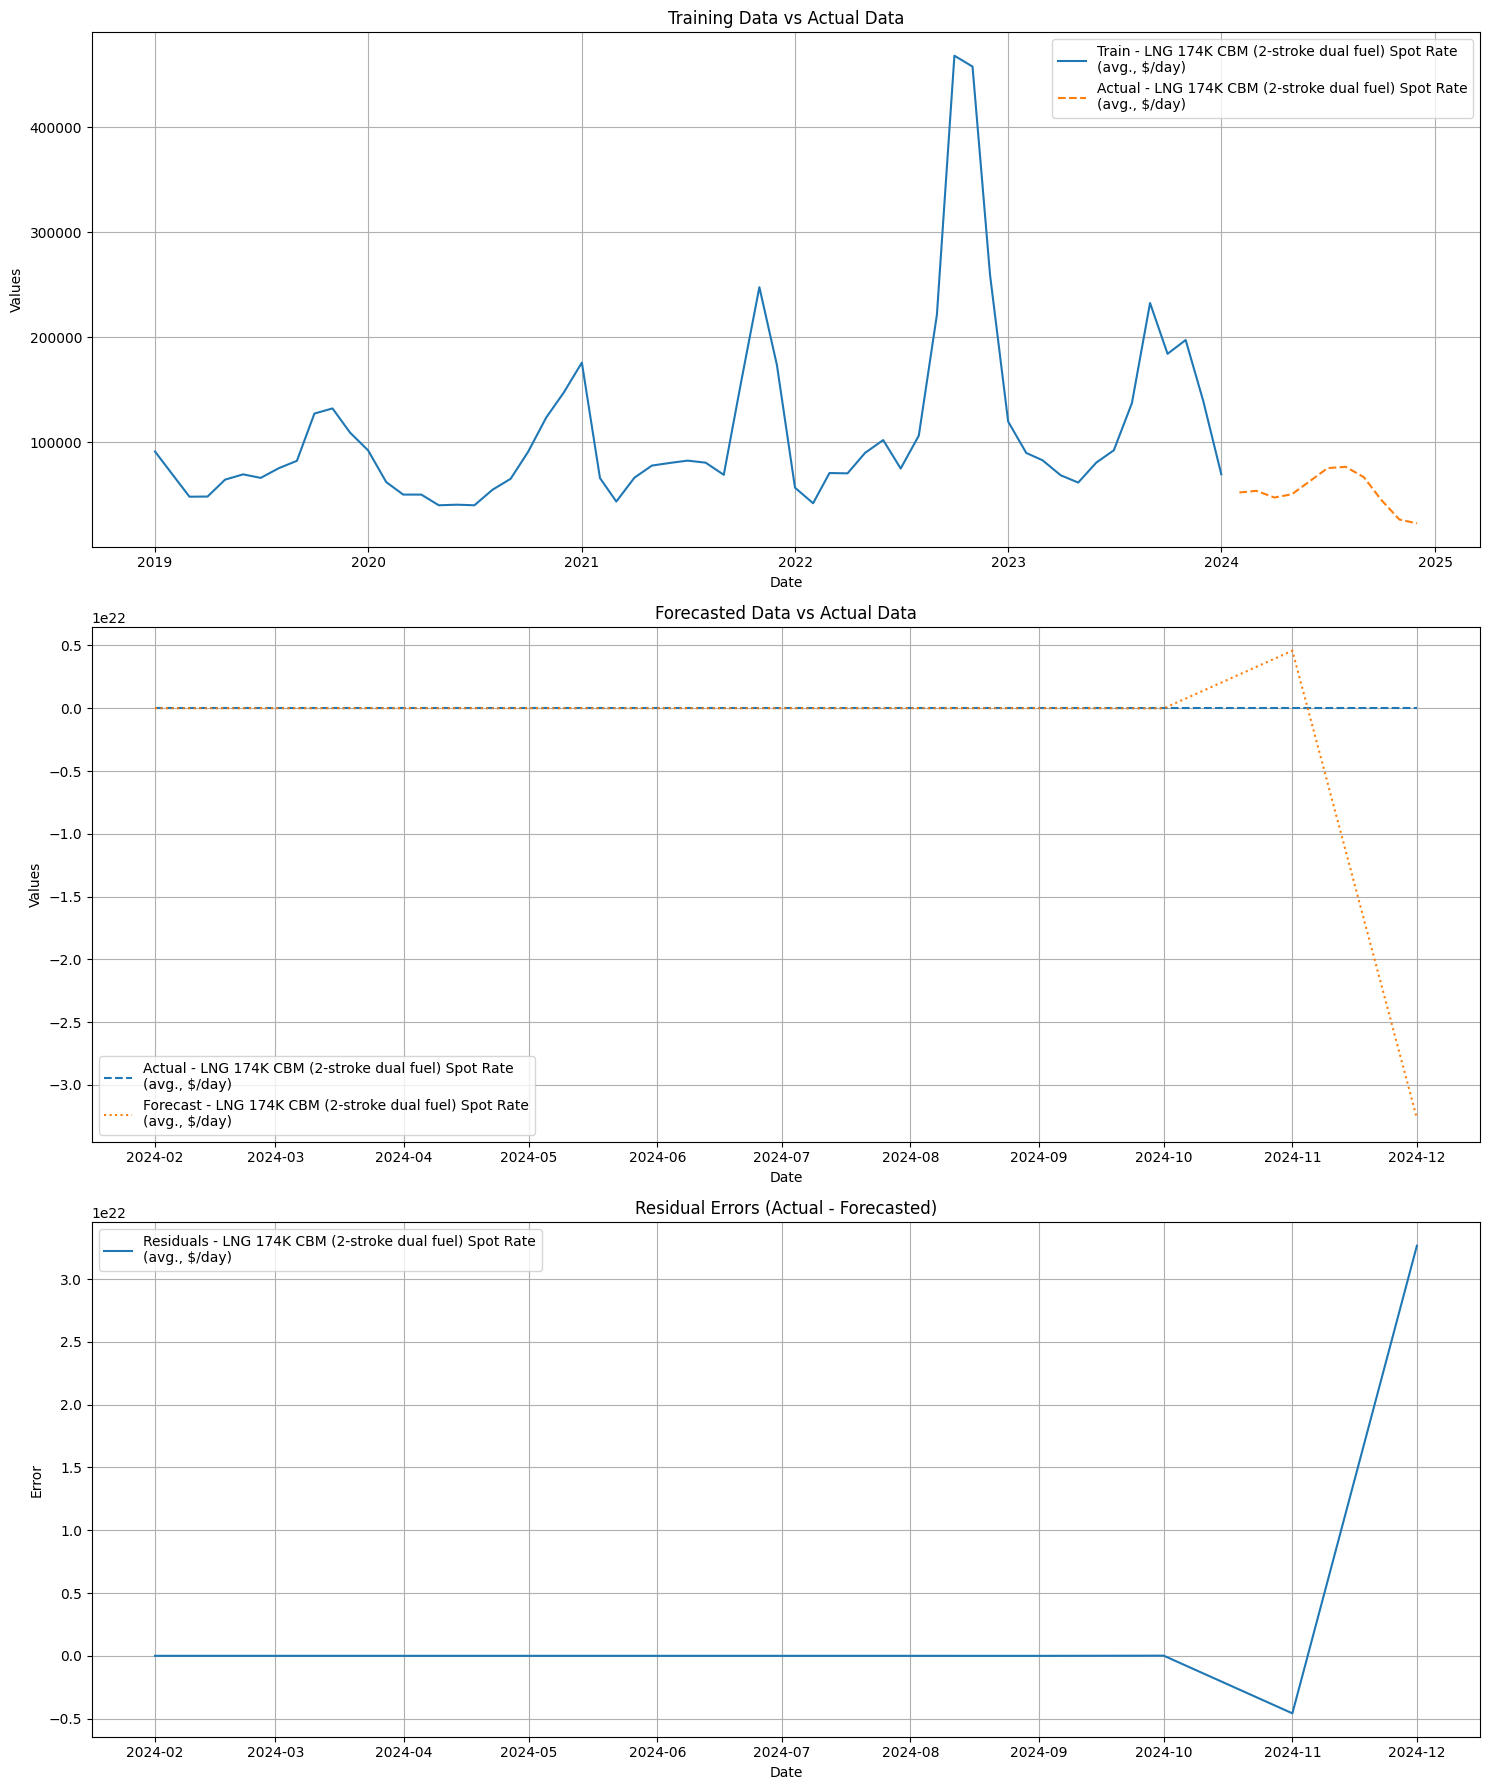

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# --- Load & preprocess data ---
data = pd.read_csv("datatest_3.csv")
data['Date'] = pd.to_datetime(data['Date'], format="%b-%Y")
data.set_index('Date', inplace=True)
data = data.apply(pd.to_numeric, errors='coerce')

# Drop unnecessary columns
data = data.drop(columns=[
    'LNG 145K CBM (Steam Turbine) Spot Rate\n(avg., $/day)',
    'Aprox.\nShip on order',
    'LNG Carrier Newbuilding Prices (end month, $m)',
    'Global price of Natural Gas, Asia (start month, MMBTU)',
    'Global price of Natural Gas, EU (start month, MMBTU)',
    'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
    'LNG Orderbook (start month, CBM)'
])

# --- Make data stationary ---
for col in data.columns:
    pval = adfuller(data[col].dropna())[1]
    if pval > 0.05:
        print(f"{col} is non-stationary, differencing...")
        data[col] = data[col].diff()

data.dropna(inplace=True)

# --- Scale data ---
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)

# --- Train-test split ---
train_size = int(len(scaled_data) * 0.85)
train, test = scaled_data.iloc[:train_size], scaled_data.iloc[train_size:]

# --- Select best lag manually ---
model = VAR(train)

best_aic = float('inf')
best_lag = 1
best_model_fit = None

for lag in range(1, 11):
    try:
        fit = model.fit(lag)
        if fit.aic < best_aic:
            best_aic = fit.aic
            best_lag = lag
            best_model_fit = fit
    except np.linalg.LinAlgError:
        print(f"Lag {lag} failed due to matrix error.")
        continue

print(f"\n✅ Best lag selected: {best_lag} (AIC = {best_aic:.4f})")

# --- Forecast ---
forecast_scaled = best_model_fit.forecast(train.values[-best_lag:], steps=len(test))

# Inverse transform forecast back to original scale
forecast_inverse = scaler.inverse_transform(forecast_scaled)
forecast_df = pd.DataFrame(forecast_inverse, index=test.index, columns=data.columns)

# Inverse transform test data for comparison
test_original = pd.DataFrame(scaler.inverse_transform(test), index=test.index, columns=data.columns)

# --- Evaluate MSE ---
mse_values = {col: mean_squared_error(test_original[col], forecast_df[col]) for col in data.columns}
print("\n📊 Mean Squared Errors:")
for col, mse in mse_values.items():
    print(f"{col}: {mse:.2f}")

# --- Plotting ---
plotcolumns = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate\n(avg., $/day)']
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# 1. Train vs Actual
axes[0].set_title("Training Data vs Actual Data")
for col in plotcolumns:
    axes[0].plot(data.index[:train_size], data[col].iloc[:train_size], label=f"Train - {col}")
    axes[0].plot(data.index[train_size:], data[col].iloc[train_size:], label=f"Actual - {col}", linestyle="dashed")
axes[0].legend()
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Values")
axes[0].grid(True)

# 2. Forecast vs Actual
axes[1].set_title("Forecasted Data vs Actual Data")
for col in plotcolumns:
    axes[1].plot(test_original.index, test_original[col], label=f"Actual - {col}", linestyle="dashed")
    axes[1].plot(forecast_df.index, forecast_df[col], label=f"Forecast - {col}", linestyle="dotted")
axes[1].legend()
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Values")
axes[1].grid(True)

# 3. Residuals
axes[2].set_title("Residual Errors (Actual - Forecasted)")
for col in plotcolumns:
    residuals = test_original[col] - forecast_df[col]
    axes[2].plot(residuals.index, residuals, label=f"Residuals - {col}")
axes[2].legend()
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Error")
axes[2].grid(True)

plt.tight_layout()
plt.show()
